In [2]:
#
import pandas as pd
import numpy as np
import json as json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [3]:
 # Loading the data from CSV into panadas dataframe
tempCashFlow = pd.read_csv (r'../data/cash_flow.csv', sep=',')
tempMonthly = pd.read_csv (r'../data/monthly-data.csv', sep=',')
TickerSymbols = pd.read_csv (r'../data/nasdaq_screener_sorted_values.csv', sep=',')

In [4]:
print(tempCashFlow.shape)
print(tempCashFlow.columns)

(3885, 30)
Index(['fiscalDateEnding', 'reportedCurrency', 'operatingCashflow',
       'paymentsForOperatingActivities', 'proceedsFromOperatingActivities',
       'changeInOperatingLiabilities', 'changeInOperatingAssets',
       'depreciationDepletionAndAmortization', 'capitalExpenditures',
       'changeInReceivables', 'changeInInventory', 'profitLoss',
       'cashflowFromInvestment', 'cashflowFromFinancing',
       'proceedsFromRepaymentsOfShortTermDebt',
       'paymentsForRepurchaseOfCommonStock', 'paymentsForRepurchaseOfEquity',
       'paymentsForRepurchaseOfPreferredStock', 'dividendPayout',
       'dividendPayoutCommonStock', 'dividendPayoutPreferredStock',
       'proceedsFromIssuanceOfCommonStock',
       'proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet',
       'proceedsFromIssuanceOfPreferredStock',
       'proceedsFromRepurchaseOfEquity', 'proceedsFromSaleOfTreasuryStock',
       'changeInCashAndCashEquivalents', 'changeInExchangeRate', 'netIncome',
       'symbo

In [5]:
# renaming Balance sheet column "fiscalDateEnding" to "timestamp" to match column name on both dataframes
tempCashFlow = tempCashFlow.rename(columns={"fiscalDateEnding": "timestamp"})


# Daily dates does not overlap on both dataframes, CompanyMonthly has the last trading day (not including weekends)
# While CompanyBalanaceSheet always has the last day of the month (including weekends)
# We need to cut out the daily date for both dataframes["timestamp"], to be able to merge them properly.
# Slicing the timestamp in CompanyMonthly, removing the days
sliceMonthly = tempMonthly["timestamp"].str.slice(0, -3)
tempMonthly["timestamp"] = sliceMonthly

# Printing
print(tempMonthly["timestamp"])

# Slicing the timestamp in CompanyBalanceSheet, removing the days
sliceCashFlow = tempCashFlow["timestamp"].str.slice(0, -3)
# For some reason i needed to use Iloc here, don't know why... 
tempCashFlow["timestamp"] = sliceCashFlow

# Printing
print(tempCashFlow["timestamp"])

# printing
print(TickerSymbols["Symbol"])
    

0        2021-11
1        2021-10
2        2021-09
3        2021-08
4        2021-07
          ...   
43662    2000-11
43663    2000-10
43664    2000-09
43665    2000-08
43666    2000-07
Name: timestamp, Length: 43667, dtype: object
0       2021-09
1       2021-06
2       2021-03
3       2020-12
4       2020-09
         ...   
3880    2017-05
3881    2017-02
3882    2016-11
3883    2016-08
3884    2016-05
Name: timestamp, Length: 3885, dtype: object
0       AAPL
1       MSFT
2       GOOG
3      GOOGL
4       AMZN
       ...  
195     STLA
196      NIO
197      UBS
198     CRWD
199     MRVL
Name: Symbol, Length: 200, dtype: object


In [6]:
# for each company we want to make adjustments needed for each companys features and then we will merge them into one df

#------------ add error if ticker symbol is not in TickerSymbols["Symbol"] or size < 200


TickerSymbols = TickerSymbols[~TickerSymbols['Symbol'].isin(['RIVN'])]
final_df = pd.DataFrame()
counter = 0

for tickerSymbol in TickerSymbols["Symbol"]:
    counter = counter +1
    print("this is the beginning of the forloop, tickersymbol: " + tickerSymbol + "counter = " + str(counter))
    
    # filter both dataframes to only use a certain stock, in this case Apple (AAPL)
    CompanyCashFlow = tempCashFlow.loc[tempCashFlow["symbol"] == tickerSymbol]
    CompanyMonthly = tempMonthly.loc[tempMonthly["Symbol"] == tickerSymbol]
    
    # printing
    #print(CompanyIncomestatement)
    #print(CompanyMonthly)
    
    # Cutting out unecessary data from the CompanyMonthly
    # We only need price data in CompanyMonthly within the daterange of the 20 rows on CompanyBalanceSheet data
    # every row is 3 months in CompanyBalanceSheet. Every row in CompanyMonthly is 1 month, 3x20 = 60.
    idx = (CompanyMonthly.index[0]+60)
    CompanyMonthly = CompanyMonthly.loc[:idx]

    # printing
    #print(CompanyMonthly.shape)
    
    # merging the rows from balance sheet and monthly on timestamp.
    merged_df = pd.merge(CompanyCashFlow, CompanyMonthly, how="outer", on = "timestamp")

    # Printing
    #print(merged_df.head(21))
    
    # removing the rows over 20
    merged_df = merged_df.loc[:19]

    # calculate how much the increase is in percentage, interval of 3 months
    # also offsetting by 1, to get the labels on the correct row.
    cat = ["timestamp", "symbol", "close", "change"]
    merged_df["change"] = merged_df["close"].pct_change(periods = -1).shift(periods = 1)
    #print("This is the data for: " + tickerSymbol)    
    #print(merged_df[cat].head(20))
    
    # Removing the first row, because we do not have a label for it, 3 months have not passed yet for us to get the end price of the 3 month cycle
    merged_df.drop(index=merged_df.index[0], axis=0, inplace=True)
    #print(merged_df[cat].head(25))
    
    # Check datatypes in dataframe
    #print(merged_df.dtypes)

    # Also dropping columns that we do not need, symbol, Symbol, open, high, low, close, volume etc.
    merged_df.drop(['symbol', 'Symbol', 'open','high','low','close','volume',"timestamp", "reportedCurrency"], axis=1, inplace=True)

    # replacing all "None" strings with NaN data type
    merged_df = merged_df.replace('None', np.nan)

    # Checking for "None" Strings
    sub_df = merged_df.loc[: , (merged_df == 'None').any()]
    #print(sub_df)

    # Casting all values to floats to calculate coffeicent and confusion matrix
    #merged_df = merged_df.astype("float64")
    #print(merged_df.dtypes)

    # Checking for "None" Strings
    sub_df = merged_df.loc[: , (merged_df == 'None').any()]
    print(sub_df)
    
    for col in merged_df.columns:
        if col != "timestamp":
            merged_df[col] = merged_df[col].astype("float")
            merged_df[col] = merged_df[col].replace(np.nan, merged_df[col].mean())
        #print("Column name: " + col + ", has mean value: " + str(merged_df[col].mean()))
    #print(merged_df.isnull().values.any())
    #print(merged_df.head())
    
    # adding it to the final dataframe
    final_df = pd.concat([final_df, merged_df], axis=0)
    #final_df.append(merged_df, ignore_index=True)

    # Make new cell where we calculated the number of "none"/NA/NaN values for each feature (column in balancesheet)

this is the beginning of the forloop, tickersymbol: AAPLcounter = 1
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: MSFTcounter = 2
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: GOOGcounter = 3
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: GOOGLcounter = 4
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: AMZNcounter = 5
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: TSLAcounter = 6
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1

this is the beginning of the forloop, tickersymbol: MCDcounter = 53
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: AMDcounter = 54
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: NVScounter = 55
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: UPScounter = 56
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: INTUcounter = 57
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: TXNcounter = 58
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1

this is the beginning of the forloop, tickersymbol: AMTcounter = 103
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: AMGNcounter = 104
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: DEcounter = 105
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: SPGIcounter = 106
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: PLDcounter = 107
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: TEAMcounter = 108
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11

this is the beginning of the forloop, tickersymbol: CCIcounter = 152
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: BNScounter = 153
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: CSXcounter = 154
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: Fcounter = 155
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
this is the beginning of the forloop, tickersymbol: DASHcounter = 156
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
this is the beginning of the forloop, tickersymbol: RBLXcounter = 157
Empty DataFrame
Columns: []
Index: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
this is the beginning of the

In [7]:
print(final_df)
print(final_df.columns)
print(final_df.dtypes)

    operatingCashflow  paymentsForOperatingActivities  \
1        2.109400e+10                    5.430000e+08   
2        2.398100e+10                    7.080000e+08   
3        3.876300e+10                    6.190000e+08   
4        2.057600e+10                    1.127000e+09   
5        1.627100e+10                    3.880000e+08   
..                ...                             ...   
15       1.010000e+08                             NaN   
16       1.342000e+08                             NaN   
17       1.189000e+08                             NaN   
18       1.214000e+08                             NaN   
19       5.930000e+07                             NaN   

    proceedsFromOperatingActivities  changeInOperatingLiabilities  \
1                               NaN                 -2.275000e+09   
2                               NaN                 -2.828000e+10   
3                               NaN                  3.097000e+10   
4                               NaN    

change                                                       1.000000
proceedsFromIssuanceOfCommonStock                            0.038103
proceedsFromRepaymentsOfShortTermDebt                        0.028446
changeInOperatingAssets                                      0.020843
changeInCashAndCashEquivalents                               0.008916
changeInOperatingLiabilities                                 0.006957
proceedsFromIssuanceOfPreferredStock                         0.004917
dividendPayoutCommonStock                                    0.002019
dividendPayout                                               0.001992
proceedsFromRepurchaseOfEquity                               0.001739
cashflowFromFinancing                                        0.001661
operatingCashflow                                            0.000196
changeInReceivables                                         -0.001051
capitalExpenditures                                         -0.002779
cashflowFromInvestme

<AxesSubplot:>

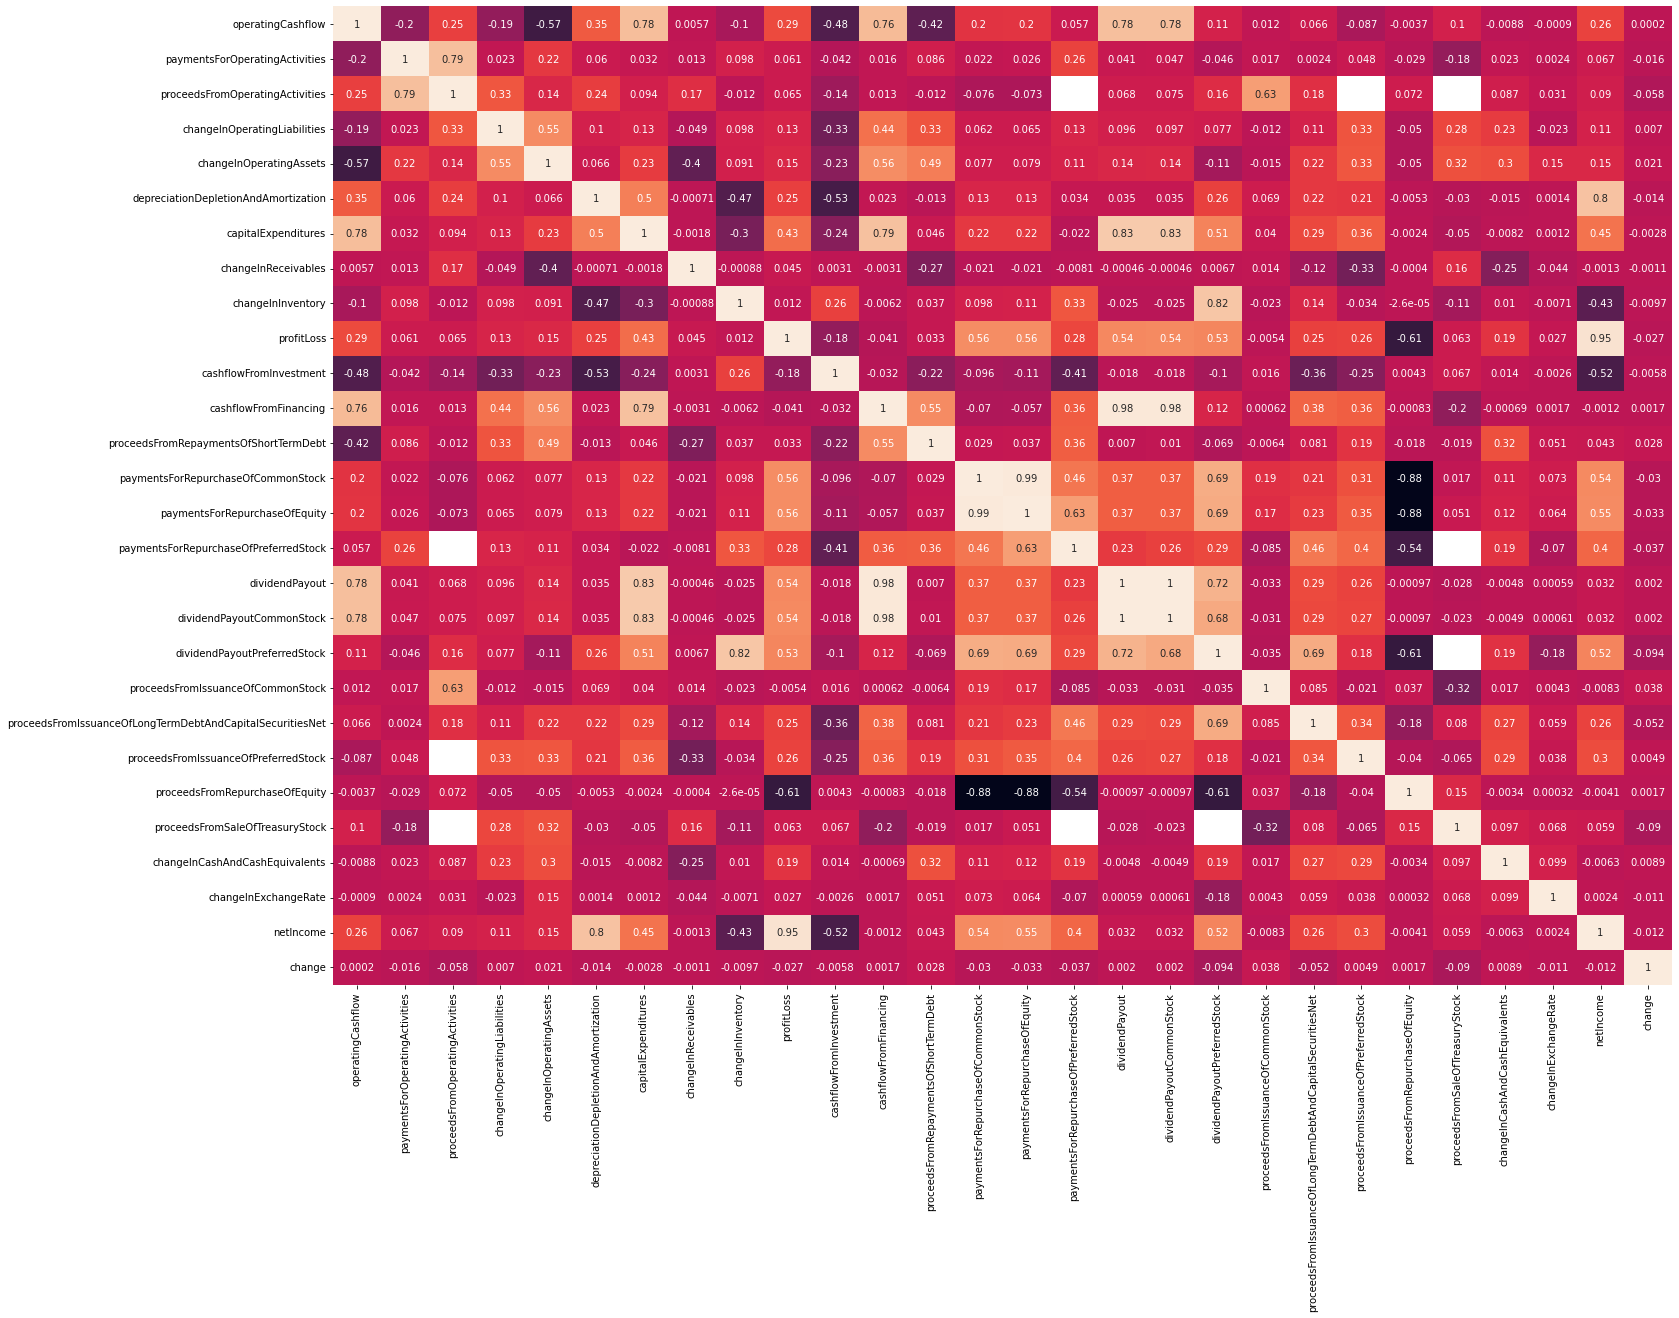

In [8]:
# correlation calculation
feature_corr = final_df.copy().corr()

# Then, print correlation of 'Sale Price' with other features from 'feature_corr' and sort  in descending order
#  ===== YOUR CODE HERE ==========
sortedDesc = feature_corr["change"].sort_values(ascending=False) 
print(sortedDesc)

#cf_matrix = confusion_matrix(feature_corr)
plt.figure(figsize = (24,18))
sns.heatmap(feature_corr, annot=True, cbar=False, )